In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Set device to CUDA if available, else CPU

from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

import random

from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive to access the dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Image shape: 1x28x28

In [2]:
#with np.load('/content/drive/My Drive/School/Senior Year (2023-2024)/Fall Semester/CS539/EnglishCharactersNoSplit.npz') as data:
with np.load('/content/drive/My Drive/CS539: Handwritten Letter Language Classifier/data/processed/EnglishCharactersNoSplit.npz') as data:
    X = data['X']
    y = data['y']

num_classes = 26 #number of letters to consider

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=24, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=24, stratify=y_val)

class LetterDataset(Dataset):
    def __init__(self, dataset, labels):
        self.dataset = dataset
        # Convert one-hot labels to class indices if they are one-hot encoded
        if len(labels.shape) > 1:  # Assuming labels are one-hot encoded if they have more than 1 dimension
            self.labels = np.argmax(labels, axis=1)
        else:
            self.labels = labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data_tensor = torch.tensor(self.dataset[idx], dtype=torch.float)
        data_tensor = data_tensor.permute(2, 0, 1)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)  # Change dtype to torch.long
        return data_tensor, label_tensor

db_train, db_val, db_test = LetterDataset(X_train, y_train), LetterDataset(X_val, y_val), LetterDataset(X_test, y_test)

In [3]:
model = nn.Sequential(
    nn.Conv2d(1, 28, kernel_size=(3,3)),    # First convolutional layer
    nn.ReLU(),                              # Activation function
    nn.Conv2d(28, 56, kernel_size=(3,3)),   # Second convolutional layer
    nn.ReLU(),                              # Activation function
    nn.Conv2d(56, 112, kernel_size=(4,4)),  # Third convolutional layer
    nn.ReLU(),                              # Activation function
    nn.MaxPool2d(kernel_size=(2,2)),        # Max pooling layer
    nn.Dropout(0.25),                       # Dropout for regularization
    nn.Flatten(),                           # Flatten the output for the dense layer
    nn.Linear(11200, 112),                  # Dense layer with adjusted input size
    nn.Dropout(0.25),                       # Dropout for regularization
    nn.Linear(112, num_classes)             # Output layer with `num_classes` outputs
)

In [4]:
import tqdm

def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, mean=0, std=0.005)

def accuracy(pred, labels):
    return (pred.argmax(-1) == labels).float().mean()


@torch.no_grad()
def eval(model, loader):
    accuracies = []
    for images, labels in tqdm.tqdm(loader):
        # Prepare data
        images = images.to(device)
        labels = labels.to(device)

        # Compute predictions, loss and accuracy
        pred = model(images)
        acc = accuracy(pred, labels)
        accuracies.append(acc.detach().item())
    return np.mean(accuracies)

def fit_one_epoch(model, opt, loader):
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        # Prepare data
        images = images.to(device)
        labels = labels.to(device)

        # Compute predictions, loss and accuracy
        pred = model(images)
        l = loss(pred, labels)
        acc = accuracy(pred, labels)

        # Compute gradients and update the model
        opt.zero_grad()
        l.backward()
        opt.step()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)


def fit(model, loader_train, loader_test, epochs=10):
    opt = torch.optim.Adam(model.parameters(), lr=0.0005)
    hist_tr_loss, hist_tr_acc, hist_te_acc = [], [], []
    for epoch in range(epochs):
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)
        te_acc = eval(model, loader_test)

        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}   Train Acc = {tr_acc:.3f}   Test Acc = {te_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_tr_acc.append(tr_acc)
        hist_te_acc.append(te_acc)
    return hist_tr_loss, hist_tr_acc, hist_te_acc

db_train.transform = transforms.Compose([
    transforms.RandomAffine(degrees=90, translate=(0.2,0.2), scale=(1,1.2)),
    transforms.ToTensor()
])

loader_train = DataLoader(db_train, batch_size=64, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
loss = nn.CrossEntropyLoss()
model = model.to(device).float()
init_weights(model)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test, epochs=30)

100%|██████████| 17/17 [00:00<00:00, 224.41it/s]

Finished epoch 0 of 30: Train Loss = 3.255   Train Acc = 0.049   Test Acc = 0.053



100%|██████████| 17/17 [00:00<00:00, 240.44it/s]

Finished epoch 1 of 30: Train Loss = 3.243   Train Acc = 0.057   Test Acc = 0.053



100%|██████████| 17/17 [00:00<00:00, 236.34it/s]

Finished epoch 2 of 30: Train Loss = 1.994   Train Acc = 0.420   Test Acc = 0.624



100%|██████████| 17/17 [00:00<00:00, 236.97it/s]

Finished epoch 3 of 30: Train Loss = 1.041   Train Acc = 0.707   Test Acc = 0.744



100%|██████████| 17/17 [00:00<00:00, 233.76it/s]

Finished epoch 4 of 30: Train Loss = 0.895   Train Acc = 0.754   Test Acc = 0.767



100%|██████████| 17/17 [00:00<00:00, 231.60it/s]

Finished epoch 5 of 30: Train Loss = 0.803   Train Acc = 0.773   Test Acc = 0.789



100%|██████████| 17/17 [00:00<00:00, 245.11it/s]

Finished epoch 6 of 30: Train Loss = 0.696   Train Acc = 0.809   Test Acc = 0.816



100%|██████████| 17/17 [00:00<00:00, 239.81it/s]

Finished epoch 7 of 30: Train Loss = 0.623   Train Acc = 0.827   Test Acc = 0.829



100%|██████████| 17/17 [00:00<00:00, 198.63it/s]

Finished epoch 8 of 30: Train Loss = 0.541   Train Acc = 0.846   Test Acc = 0.857



100%|██████████| 17/17 [00:00<00:00, 200.66it/s]

Finished epoch 9 of 30: Train Loss = 0.474   Train Acc = 0.867   Test Acc = 0.877



100%|██████████| 17/17 [00:00<00:00, 200.56it/s]

Finished epoch 10 of 30: Train Loss = 0.410   Train Acc = 0.885   Test Acc = 0.873



100%|██████████| 17/17 [00:00<00:00, 186.22it/s]

Finished epoch 11 of 30: Train Loss = 0.371   Train Acc = 0.894   Test Acc = 0.883



100%|██████████| 17/17 [00:00<00:00, 202.53it/s]

Finished epoch 12 of 30: Train Loss = 0.330   Train Acc = 0.904   Test Acc = 0.890



100%|██████████| 17/17 [00:00<00:00, 192.36it/s]

Finished epoch 13 of 30: Train Loss = 0.305   Train Acc = 0.910   Test Acc = 0.882



100%|██████████| 17/17 [00:00<00:00, 200.28it/s]

Finished epoch 14 of 30: Train Loss = 0.286   Train Acc = 0.922   Test Acc = 0.898



100%|██████████| 17/17 [00:00<00:00, 233.27it/s]

Finished epoch 15 of 30: Train Loss = 0.257   Train Acc = 0.927   Test Acc = 0.897



100%|██████████| 17/17 [00:00<00:00, 240.22it/s]

Finished epoch 16 of 30: Train Loss = 0.246   Train Acc = 0.930   Test Acc = 0.898



100%|██████████| 17/17 [00:00<00:00, 244.33it/s]

Finished epoch 17 of 30: Train Loss = 0.216   Train Acc = 0.939   Test Acc = 0.896



100%|██████████| 17/17 [00:00<00:00, 244.86it/s]

Finished epoch 18 of 30: Train Loss = 0.207   Train Acc = 0.939   Test Acc = 0.901



100%|██████████| 17/17 [00:00<00:00, 235.06it/s]

Finished epoch 19 of 30: Train Loss = 0.209   Train Acc = 0.938   Test Acc = 0.900



100%|██████████| 17/17 [00:00<00:00, 235.69it/s]

Finished epoch 20 of 30: Train Loss = 0.195   Train Acc = 0.946   Test Acc = 0.902



100%|██████████| 17/17 [00:00<00:00, 235.75it/s]

Finished epoch 21 of 30: Train Loss = 0.170   Train Acc = 0.951   Test Acc = 0.895



100%|██████████| 17/17 [00:00<00:00, 227.87it/s]

Finished epoch 22 of 30: Train Loss = 0.169   Train Acc = 0.950   Test Acc = 0.896



100%|██████████| 17/17 [00:00<00:00, 234.51it/s]

Finished epoch 23 of 30: Train Loss = 0.164   Train Acc = 0.954   Test Acc = 0.901



100%|██████████| 17/17 [00:00<00:00, 237.20it/s]

Finished epoch 24 of 30: Train Loss = 0.153   Train Acc = 0.952   Test Acc = 0.897



100%|██████████| 17/17 [00:00<00:00, 235.64it/s]

Finished epoch 25 of 30: Train Loss = 0.153   Train Acc = 0.954   Test Acc = 0.906



100%|██████████| 17/17 [00:00<00:00, 212.09it/s]

Finished epoch 26 of 30: Train Loss = 0.128   Train Acc = 0.964   Test Acc = 0.895



100%|██████████| 17/17 [00:00<00:00, 239.24it/s]

Finished epoch 27 of 30: Train Loss = 0.130   Train Acc = 0.959   Test Acc = 0.903



100%|██████████| 17/17 [00:00<00:00, 202.68it/s]

Finished epoch 28 of 30: Train Loss = 0.114   Train Acc = 0.966   Test Acc = 0.849



100%|██████████| 17/17 [00:00<00:00, 202.56it/s]

Finished epoch 29 of 30: Train Loss = 0.114   Train Acc = 0.963   Test Acc = 0.900


100%|██████████| 17/17 [00:00<00:00, 215.27it/s]


Test accuracy: 90.17%


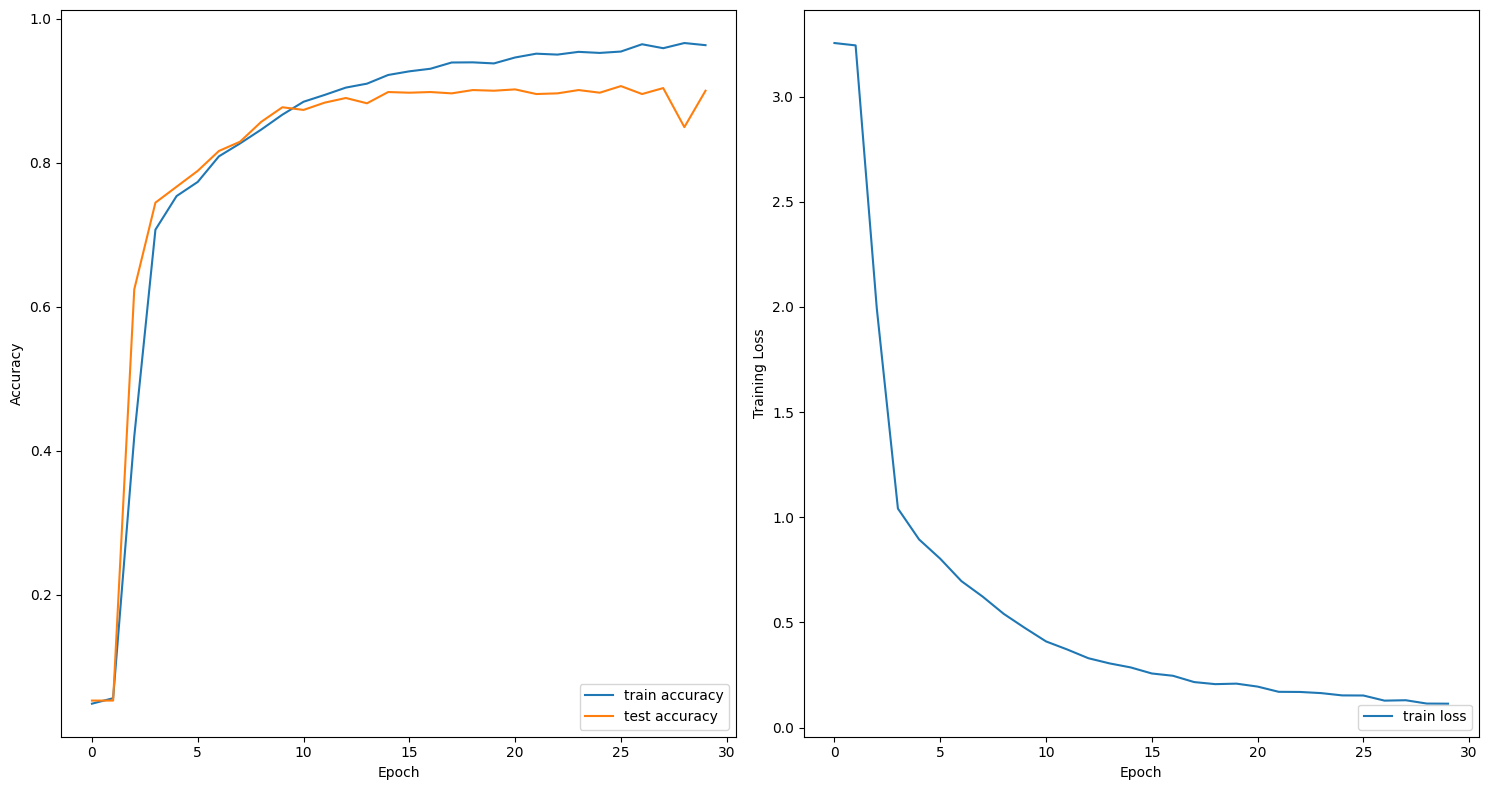

In [5]:
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.plot(hist_tr_acc, label='train accuracy')
plt.plot(hist_te_acc, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(hist_tr_loss, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(loc='lower right')
plt.tight_layout()

acc = eval(model, loader_test)
print(f'Test accuracy: {acc*100:.2f}%')

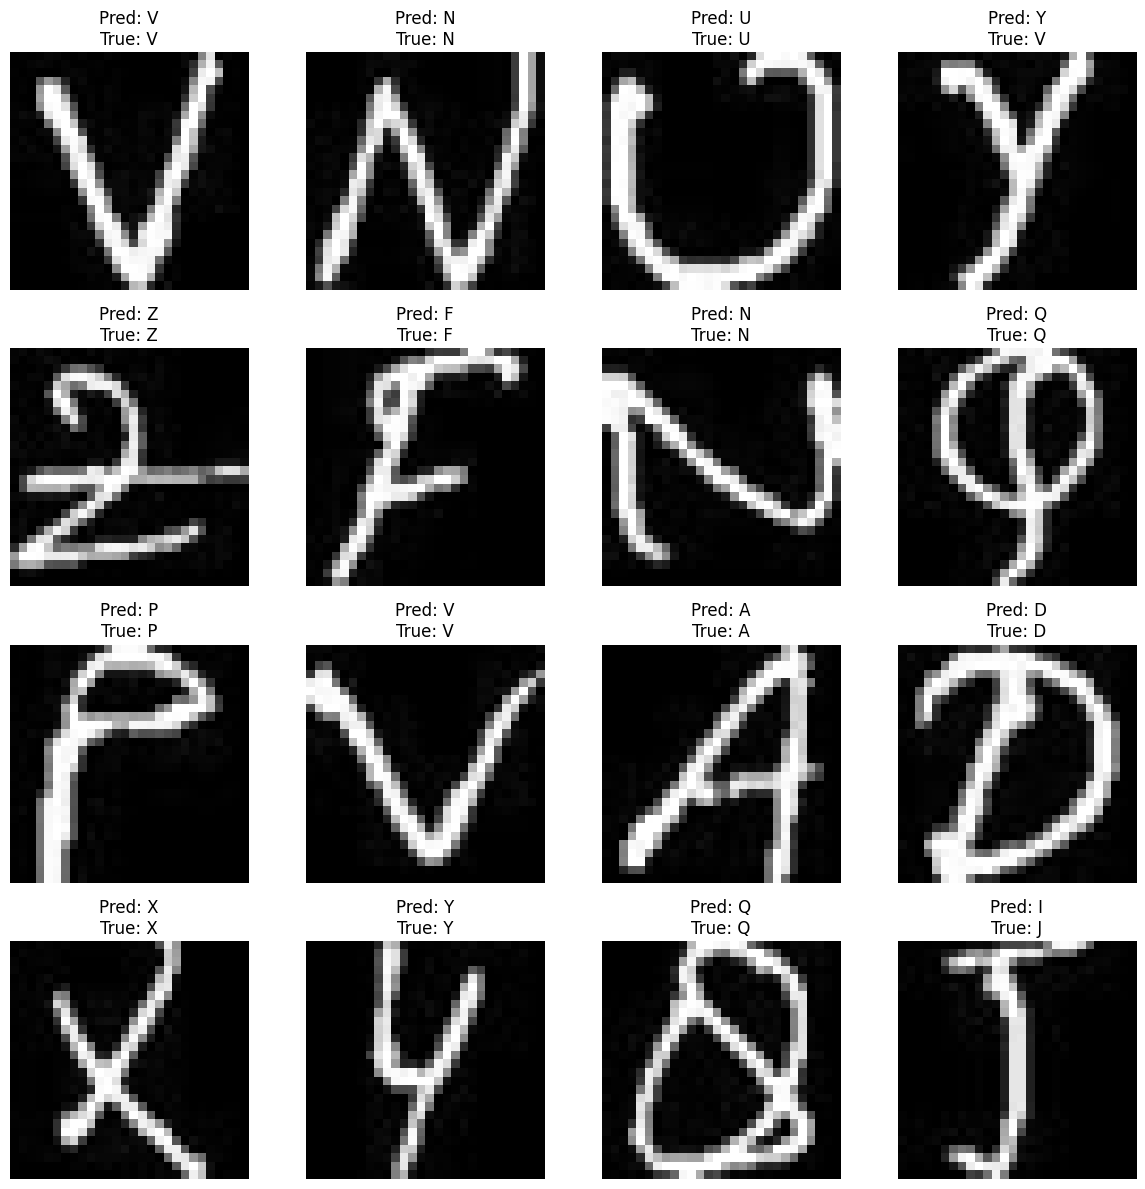

In [6]:
import matplotlib.pyplot as plt

# Function to show images, predictions, and true labels
def show_predictions(loader, model, classes, num_images=16, rows=4, cols=4):
    # Set model to evaluation mode
    model.eval()

    # Get a batch of images and labels from the loader
    images, labels = next(iter(loader))

    # Move images to the same device as the model
    images = images.to(device)

    # Make predictions
    preds = model(images)
    preds = torch.argmax(preds, dim=1)

    # Move images and labels back to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    # Create a figure to display the images
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    for i in range(num_images):
        ax = axes[i // cols, i % cols]
        img = images[i].permute(1, 2, 0)  # Change (C, H, W) to (H, W, C) for displaying

        # Display the image
        ax.imshow(img.squeeze(), cmap='gray')  # Remove the channel dimension if it's 1

        # Set the title of the subplot to the predicted and true labels
        ax.set_title(f'Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}')

        # Hide the axes
        ax.axis('off')

    # Adjust subplot parameters for a clean layout
    plt.tight_layout()
    plt.show()

# Define the class names (assuming they are letters A-Z)
class_names = [chr(i) for i in range(65, 65 + num_classes)]

# Call the function to show the predictions
show_predictions(loader_test, model, class_names, num_images=16, rows=4, cols=4)
